In [ ]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## 1. Basic Perceptron Implementation


In [ ]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0], [0], [0], [1]])

# Initialize weights and bias
np.random.seed(42)
W = np.random.randn(2, 1)
b = np.random.randn(1)
lr = 0.1  # learning rate


# Sigmoid activation
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


# Training loop
for epoch in range(1000):
    z = np.dot(X, W) + b
    y_pred = sigmoid(z)
    loss = np.mean((y - y_pred) ** 2)

    # Backpropagation
    dL_dy = -(y - y_pred)
    dy_dz = y_pred * (1 - y_pred)
    dL_dz = dL_dy * dy_dz

    dW = np.dot(X.T, dL_dz) / len(X)
    db = np.sum(dL_dz) / len(X)

    W -= lr * dW
    b -= lr * db

print("Final weights:", W)
print("Final bias:", b)

Final weights: [[1.15916535]
 [1.04821395]]
Final bias: [-1.89026566]


## 2. Digit Classification System (MNIST)


In [ ]:
# Load dataset
digits = load_digits()
X = digits.data / 16.0  # normalization
y = digits.target.reshape(-1, 1)

# One-hot encoding
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# Initialize parameters
input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = 10

np.random.seed(0)
W1 = np.random.randn(input_dim, hidden_dim) * 0.01
b1 = np.zeros((1, hidden_dim))
W2 = np.random.randn(hidden_dim, output_dim) * 0.01
b2 = np.zeros((1, output_dim))
lr = 0.1


# Activation functions
def relu(z):
    return np.maximum(0, z)


def relu_deriv(z):
    return (z > 0).astype(float)


def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)


# Training
for epoch in range(2000):
    z1 = np.dot(X_train, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = softmax(z2)

    loss = -np.mean(np.sum(y_train * np.log(a2 + 1e-9), axis=1))

    # Backpropagation
    dz2 = a2 - y_train
    dW2 = np.dot(a1.T, dz2) / len(X_train)
    db2 = np.sum(dz2, axis=0, keepdims=True) / len(X_train)

    dz1 = np.dot(dz2, W2.T) * relu_deriv(z1)
    dW1 = np.dot(X_train.T, dz1) / len(X_train)
    db1 = np.sum(dz1, axis=0, keepdims=True) / len(X_train)

    # Update
    W1 -= lr * dW1
    W2 -= lr * dW2
    b1 -= lr * db1
    b2 -= lr * db2

print("Final training loss:", loss)

Final training loss: 0.07140683003760424


## 3. Neural Network Implementation


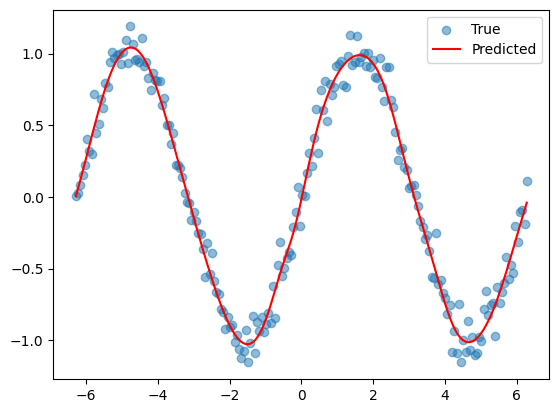

In [ ]:
# Data generation
x = torch.linspace(-2 * np.pi, 2 * np.pi, 200).unsqueeze(1)
y = torch.sin(x) + 0.1 * torch.randn(x.size())


# Model
class FeedforwardNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(1, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 1)
        self.act = nn.Tanh()

    def forward(self, x):
        x = self.act(self.hidden1(x))
        x = self.act(self.hidden2(x))
        return self.out(x)


model = FeedforwardNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(
    model.parameters(), lr=0.01, weight_decay=1e-4
)  # L2 regularization

# Training
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

# Plot results
plt.scatter(x.detach(), y.detach(), label="True", alpha=0.5)
plt.plot(x.detach(), model(x).detach(), color="r", label="Predicted")
plt.legend()
plt.show()

## Classification: FashionMNIST with CNN


In [ ]:
# Data preprocessing
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

trainset = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)
testset = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


# CNN model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)  # Fixed: 14x14 not 7x7
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
for epoch in range(5):
    running_loss = 0.0
    for i, (images, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")

# Test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Epoch 1 - Loss: 0.3749
Epoch 2 - Loss: 0.2331
Epoch 3 - Loss: 0.1839
Epoch 4 - Loss: 0.1435
Epoch 5 - Loss: 0.1121
Test Accuracy: 92.56%
